# Water models
Here we will demonstrate how MoSDeF can be used to compare two different force fields; in this case, two atomistic water models. Here we are using two rigid, classical 3-site models, [SPC/E](https://dx.doi.org/doi/10.1021/j100308a038) and [tip3p](https://dx.doi.org/10.1063/1.445869).

First, we will use mBuild and foyer to generate initial configurations

In [1]:
import mbuild as mb
from foyer import Forcefield

In [2]:
water = mb.load('O', smiles=True)
water.name = 'water'

/Users/raymatsumoto/anaconda3/envs/mosdef37/lib/python3.7/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
/Users/raymatsumoto/mbuild/mbuild/compound.py:2746: UserWarning: No unitcell detected for pybel.Molecule O	

  warn("No unitcell detected for pybel.Molecule {}".format(pybel_mol))


In [3]:
# Generate a water compound from a SMILES string
water = mb.load('O', smiles=True)
water.name = 'water'

In [4]:
# Fill a simulation box with water molecules
system = mb.fill_box(compound=water, n_compounds=1000, density=993)

In [5]:
# Load and apply each force field
SPCE = Forcefield('files/spce.xml')
TIP3P = Forcefield('files/tip3p.xml')

system_spce = SPCE.apply(system.to_parmed(residues=['water']))
system_tip3p = TIP3P.apply(system.to_parmed(residues=['water']))

/Users/raymatsumoto/foyer/foyer/forcefield.py:433: UserWarning: No force field version number found in force field XML file.
  'No force field version number found in force field XML file.'
/Users/raymatsumoto/foyer/foyer/forcefield.py:445: UserWarning: No force field name found in force field XML file.
  'No force field name found in force field XML file.'


In [7]:
# Save GROMACS files for each system
system_spce.save('water_spce.gro', overwrite=True)
system_spce.save('water_spce.top', overwrite=True)
system_tip3p.save('water_tip3p.gro', overwrite=True)
system_tip3p.save('water_tip3p.top', overwrite=True)

Now that we have the GRO and TOP files, we can prepare and run GROMACS simulations. These should take approximately an hour each on a typical quad-core laptop.

In [ ]:
!gmx grompp -c water_spce.gro -p water_spce.top -f files/npt.mdp -o water_spce.tpr && \
 gmx grompp -c water_tip3p.gro -p water_tip3p.top -f files/npt.mdp -o water_tip3p.tpr

In [ ]:
!gmx mdrun -v -deffnm water_spce && \
 gmx mdrun -v -deffnm water_tip3p

Now that the simulations are complete, we begin our analysis. We will first do some quick time series analyses and then compute a few RDFs. The simulations equilibrate quickly, so we will only throw out the first 100 ps of the trajectories and run analyses on the last 900 ps.

In [9]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import InsetPosition

/Users/raymatsumoto/anaconda3/envs/mda/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  after removing the cwd from sys.path.


In [ ]:
!echo 4 | gmx energy -f water_spce.edr -o energy_spce.xvg

In [ ]:
!echo 4 | gmx energy -f water_tip3p.edr -o energy_tip3p.xvg

/Users/raymatsumoto/anaconda3/envs/mda/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


Text(0, 0.5, 'Potential energy, kJ/mol')

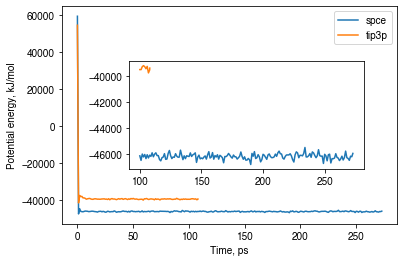

In [10]:
# Calculate the potential energy of the systems
fig, ax = plt.subplots()

for model in ['spce', 'tip3p']:
    data = np.loadtxt(f'energy_{model}.xvg', comments=['#', '@'])

    ax.plot(data[:, 0], data[:, 1], label=model)
    axins = plt.axes([0,0,1,1])

    ip = InsetPosition(ax, [0.2,0.25,0.7,0.5])
    axins.set_axes_locator(ip)

    axins.plot(data[100:, 0], data[100:, 1])

ax.legend(loc=0)
ax.set_xlabel('Time, ps')
ax.set_ylabel('Potential energy, kJ/mol')

/Users/raymatsumoto/anaconda3/envs/mda/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


Text(0, 0.5, 'Density, kg/m^3')

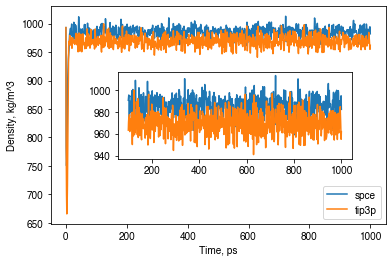

In [11]:
# Calculate the density of the systems
fig, ax = plt.subplots()

for model in ['spce', 'tip3p']:
    trj = md.load(
        f'water_{model}.xtc',
        top=f'water_{model}.gro',
    )

    rho = md.density(trj)

    ax.plot(trj.time, rho, label=model)
    axins = plt.axes([0,0,1,1])

    ip = InsetPosition(ax, [0.2,0.3,0.7,0.4])
    axins.set_axes_locator(ip)

    axins.plot(trj.time[100:], rho[100:])

ax.legend(loc='lower right')
ax.set_xlabel('Time, ps')
ax.set_ylabel('Density, kg/m^3')

Text(0, 0.5, 'Pair distribution function, unitless')

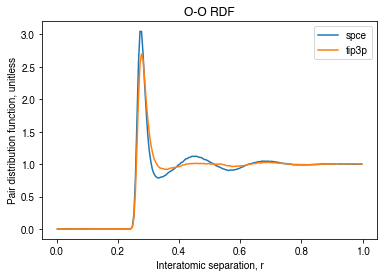

In [12]:
# Calculate the O-O RDF 
fig, ax = plt.subplots()

for model in ['spce', 'tip3p']:
    trj = md.load(
        f'water_{model}.xtc',
        top=f'water_{model}.gro',
        stride=2,
    )

    pairs = trj.top.select_pairs('name O', 'name O')

    r, g_r = md.compute_rdf(trj[100:], pairs)

    plt.plot(r, g_r, label=model)

ax.legend()
ax.set_title('O-O RDF')
ax.set_xlabel('Interatomic separation, r')
ax.set_ylabel('Radial Distribution Function, unitless')

Text(0, 0.5, 'Pair distribution function, unitless')

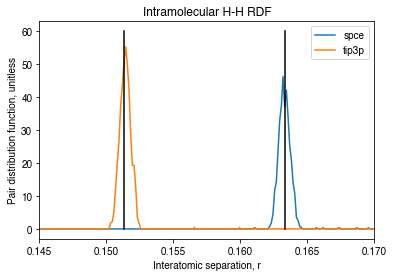

In [13]:
# Calculate the intramolecular H-H RDF
fig, ax = plt.subplots()

for model in ['spce', 'tip3p']:
    trj = md.load(
        f'water_{model}.xtc',
        top=f'water_{model}.gro',
        stride=10,
    )

    pairs = trj.top.select_pairs('name H', 'name H')

    r, g_r = md.compute_rdf(trj[100:], pairs, r_range=(0.145, 0.17), n_bins=200)

    plt.plot(r, g_r, label=model)

ax.plot([0.1633, 0.1633], [0, 60], 'k-')
ax.plot([0.1513, 0.1513], [0, 60], 'k-')

ax.legend()
ax.set_title('Intramolecular H-H RDF')
ax.set_xlim((0.145, 0.17))
ax.set_xlabel('Interatomic separation, r')
ax.set_ylabel('Radial Distribution Function, unitless')

Text(0, 0.5, 'Pair distribution function, unitless')

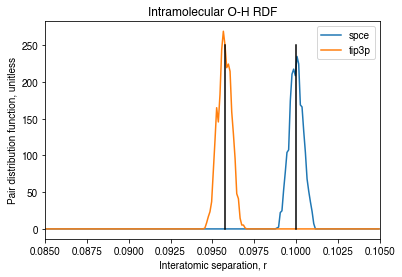

In [19]:
# Calculate the intrmolecular O-H RDF
fig, ax = plt.subplots()

for model in ['spce', 'tip3p']:
    trj = md.load(
        f'water_{model}.xtc',
        top=f'water_{model}.gro',
        stride=10,
    )

    pairs = trj.top.select_pairs('name O', 'name H')

    r, g_r = md.compute_rdf(trj[100:], pairs, r_range=(0.085, 0.105), n_bins=200)

    plt.plot(r, g_r, label=model)

ax.plot([0.09572, 0.09572], [0, 250], 'k-')
ax.plot([0.1, 0.1], [0, 250], 'k-')

ax.legend()
ax.set_title('Intramolecular O-H RDF')
ax.set_xlim((0.085, 0.105))
ax.set_xlabel('Interatomic separation, r')
ax.set_ylabel('Radial Distribution function, unitless')